In [371]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [372]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} will be used for training...")

cuda will be used for training...


In [373]:
train_data_path = os.path.join("dataset", "prototyping", "train")
valid_data_path = os.path.join("dataset", "prototyping", "valid")
print(f"Train path: {train_data_path}\nValid path: {valid_data_path}")

Train path: dataset\prototyping\train
Valid path: dataset\prototyping\valid


# 1. Defining Transforms for Data Augumentation

In [374]:
image_size = 256

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize([0, 0, 0], [1, 1, 1]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize([0, 0, 0], [1, 1, 1]),
])

In [375]:
training_data = ImageFolder(train_data_path, transform=train_transforms)
valid_data = ImageFolder(valid_data_path, transform=test_transforms)

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

In [376]:
idx_to_class = {v: k for k, v in training_data.class_to_idx.items()}
idx_to_class

{0: 'fake', 1: 'real'}

In [377]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image
  # image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

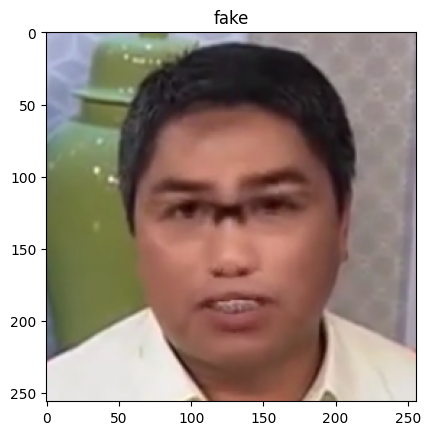

In [378]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

In [379]:
from torchvision.models import resnet152, ResNet152_Weights

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [380]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [381]:
classifier = torch.nn.Sequential(
    nn.Linear(2048, 2),
    # nn.ReLU(),
    # nn.Dropout(p=0.2),
    # nn.Linear(1024, 512),
    # nn.ReLU(),
    # nn.Dropout(p=0.15),
    # nn.Linear(512, 128),
    # nn.ReLU(),
    # nn.Dropout(p=0.15),
    # nn.Linear(128, 2),
    nn.LogSoftmax(dim=1),
)
classifier

Sequential(
  (0): Linear(in_features=2048, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)

In [382]:
for param in model.parameters():
    param.requires_grad = False

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [383]:
checkpoint_path = "checkpoint.pt"

# Hyper parameters

In [384]:
criterion = nn.NLLLoss()
epochs = 50
learning_rate = 0.005
validate_every = 5

In [385]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [386]:
validation_loss_min = np.Inf
model.to(device)

for e in range(epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  i = 0
  for images, labels in tqdm.tqdm(train_loader):
    i += 1
    # print(f"{i} / {len(train_loader)} image being used for training")
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    with torch.no_grad():
      model.eval()

      for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

    model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    if validation_loss <= validation_loss_min:
      torch.save({"state_dict": model.state_dict(), "valid_loss": validation_loss_min}, checkpoint_path)
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")
      validation_loss_min = validation_loss


EPOCH 1:


100%|██████████| 375/375 [02:12<00:00,  2.84it/s]


Epoch 1 :: Running Loss: 0.6560902999242146
EPOCH 2:


100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


Epoch 2 :: Running Loss: 0.6064608128070831
EPOCH 3:


100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


Epoch 3 :: Running Loss: 0.577039207259814
EPOCH 4:


100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


Epoch 4 :: Running Loss: 0.5647168293793996
EPOCH 5:


100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


Epoch 5 :: Running Loss: 0.567610108534495


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


EPOCH 5:
Running Loss = 0.567610108534495	Validation Loss: 0.7429102999823434
Minimum Validtion loss acquired, inf to 0.7429102999823434
EPOCH 6:


100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


Epoch 6 :: Running Loss: 0.5732421842416128
EPOCH 7:


100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


Epoch 7 :: Running Loss: 0.5724760421911875
EPOCH 8:


100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


Epoch 8 :: Running Loss: 0.5711340497334798
EPOCH 9:


100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


Epoch 9 :: Running Loss: 0.5681874013741811
EPOCH 10:


100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


Epoch 10 :: Running Loss: 0.5574892037709555


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


EPOCH 10:
Running Loss = 0.5574892037709555	Validation Loss: 1.0516889095306396
EPOCH 11:


  8%|▊         | 31/375 [00:11<02:05,  2.73it/s]


KeyboardInterrupt: 

# Metrics Calculation

In [1]:
validation_loss = 0
correct_valid = 0
total_valid = 0

with torch.no_grad():
    model.eval()

    for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)
        validation_loss += loss.item()

        # Calculate validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
        total_valid += labels.size(0)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100

print("Validation Accuracy:", validation_accuracy)

NameError: name 'torch' is not defined